# General Adversarial Networks 
Finally got Tesla K80 GPU to train this GAN

> A small port of https://www.datacamp.com/community/tutorials/generative-adversarial-networks in tensorflow keras API in Python 3

> Further tensorflow eager execution with its new Data API will be added

### Important Thing to Notice
> I noticed few interesting thing by increasing batch size as 32, 64, 128, 256 ... upto 8192.
- increasing batch size caused model to learn very slowly or in other words on moderate batch size about 128, model learned well enough given same number of epochs for each batch size.
- Mine in 940MX video card, it took almost same time even increasing batch size as opposed to rule that says more data more calc. thus more time.
- My video card has PCIe 3.0 x4 lanes, but maximum use of lanes went upto 16% only.

### Conclusion
> samll batch size is preffered for GAN's training.

> 940MX is capable of 953.9 GFLOPS (single precision 32-bit). So, maybe calculating ~17 MB of data is within the limit, need mathematical proof. But yes, on increasing batch size avg. GPU increased from 73 to 90%.

> as 128 and 8192 batch sizes means 128x28x28 bytes and 8192x28x28 bytes resp., whereas 940MX has gazillions of bytes (2GB).
Its roughly max upto ~17MB (7MB data + 10 MB weights). Thus, bandwidth is not the bottelneck for this calculation can be seen by max 16% usage.

### Improvements
> TensorFlow Data API can be used for decreasing data copying to GPU time, for more info see new Data API.

> tensorboard summary and graphs can be added for better visualization.

> And OfCourse model can be changed.

In [1]:
!pip install tqdm
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

    100% |████████████████████████████████| 51kB 4.8MB/s 


In [2]:
import  tensorflow  as tf
tf.__version__

'1.8.0'

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9974094377918051444
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 254017536
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13534238150779914276
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


In [0]:
np.random.seed(10)

random_dim = [10,]

In [0]:
# TRAINING_SIZE = len(train_images)
# TEST_SIZE = len(test_images)
def load_minst_data():
    (train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
    # Convert the array to float32 as opposed to uint8
    train_images = train_images.astype(np.float32)
    # test_images = test_images.astype(np.float32)

    # Convert the pixel values from integers between 0 and 255 to floats between 0 and 1
    train_images /= 255
    # test_images /=  255

    X = np.reshape(train_images, [-1, 28*28])
    Y  = get_one_hot(train_labels, 10)
    return (X, Y, test_images, test_labels)
# NUM_DIGITS = 10

    

# test_labels = tf.keras.utils.to_categorical(test_labels, NUM_DIGITS)

In [0]:
def get_optimizer():
    return tf.train.AdamOptimizer(learning_rate=0.0002, beta1=0.5)

In [0]:
def get_generator(optimizer):
    generator = tf.keras.models.Sequential()
    generator.add(tf.keras.layers.Dense(256, input_shape=random_dim, kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02)))
    generator.add(tf.keras.layers.LeakyReLU(0.2))
    
    generator.add(tf.keras.layers.Dense(512))
    generator.add(tf.keras.layers.LeakyReLU(0.2))
    
    generator.add(tf.keras.layers.Dense(1024))
    generator.add(tf.keras.layers.LeakyReLU(0.2))
    
    generator.add(tf.keras.layers.Dense(784, activation='tanh'))
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator

In [0]:
def get_discriminator(optimizer):
    discriminator = tf.keras.models.Sequential()
    discriminator.add(tf.keras.layers.Dense(1024, input_shape=[784,], kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02)))
    
    discriminator.add(tf.keras.layers.LeakyReLU(0.2))
    discriminator.add(tf.keras.layers.Dropout(0.3))
    
    discriminator.add(tf.keras.layers.Dense(512))
    discriminator.add(tf.keras.layers.LeakyReLU(0.2))
    discriminator.add(tf.keras.layers.Dropout(0.3))
    
    discriminator.add(tf.keras.layers.Dense(256))
    discriminator.add(tf.keras.layers.LeakyReLU(0.2))
    discriminator.add(tf.keras.layers.Dropout(0.3))
    
    discriminator.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator

In [0]:
def get_gan_network(discriminator, random_dim, generator, optimizer):
    discriminator.trainable = False
    gan_input = tf.keras.layers.Input(shape=random_dim)
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = tf.keras.models.Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    return gan

In [0]:
# Create a wall of generated MNIST images
def plot_generated_images(epoch, generator, examples=10, dim=(1, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, random_dim[0]])
#     noise = get_one_hot(np.random.randint(0, 10, size=10), 10)+np.random.uniform(0.0, 0.25, size=10)
# #     print(noise)
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)

In [0]:
def train(epochs=1, batch_size=128):
    # Get the training and testing data
    x_train, y_train, x_test, y_test = load_minst_data()
    # Split the training data into batches of size 128
    batch_count = int(x_train.shape[0] / batch_size)

    # Build our GAN netowrk
    adam = get_optimizer()
    generator = get_generator(adam)
    discriminator = get_discriminator(adam)
    gan = get_gan_network(discriminator, random_dim, generator, adam)

    for e in tqdm(range(1, epochs+1)):
#         print('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in range(batch_count):
            # Get a random set of input noise and images
#             batch_index = np.random.randint(0, x_train.shape[0], size=batch_size)
#             noise = y_train[batch_index].reshape(batch_size,-1)
#             image_batch = x_train[batch_index]
            noise = np.random.normal(0, 1, size=[batch_size, random_dim[0]])
            image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]

            # Generate fake MNIST images
            generated_images = generator.predict(noise)
            X = np.concatenate([image_batch, generated_images])

            # Labels for generated and real data
            y_dis = np.zeros(2*batch_size)
            # One-sided label smoothing
            y_dis[:batch_size] = 0.9

            # Train discriminator
            discriminator.trainable = True
            discriminator.train_on_batch(X, y_dis)

            # Train generator
            noise = np.random.normal(0, 1, size=[batch_size, random_dim[0]])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            
            gan.train_on_batch(noise, y_gen)

        if e % 20 == 0:
            plot_generated_images(e, generator)
    return generator

100%|██████████| 200/200 [33:43<00:00, 10.12s/it]


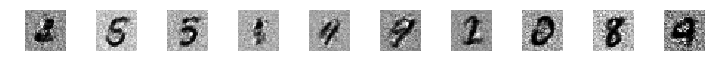

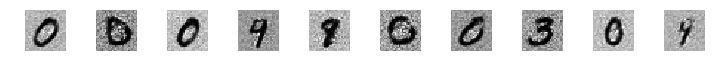

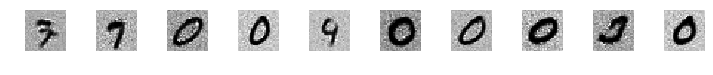

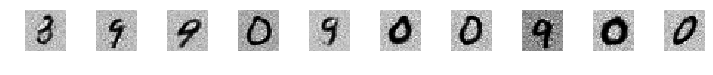

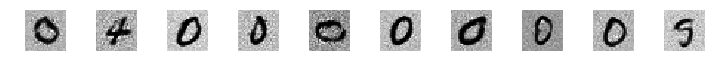

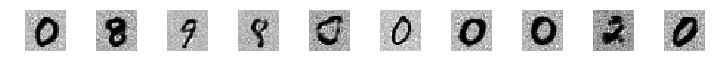

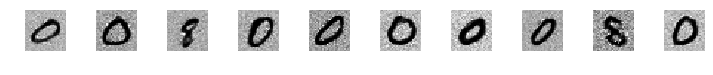

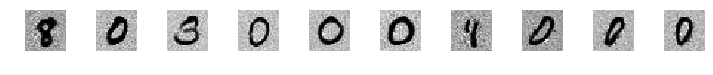

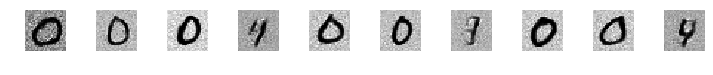

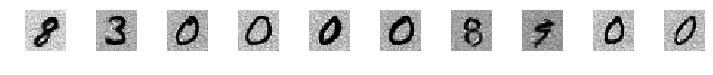

In [16]:
g = train(200, 128)

> We can see above how it learns to generate image slowly.
Each row is the result of 20 epochs calculation or in simple words seeing 60,000 images of 28x28 pixels 20 times by generator and discriminator and simultaneously updating weights and biases.

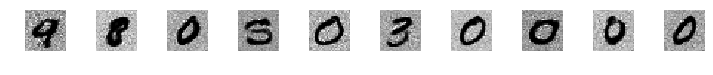

In [36]:
plot_generated_images(1, g)

In [0]:
(x, y, _, _) = load_minst_data()

In [0]:
def get_one_hot(targets, nb_classes):
    return np.eye(nb_classes)[np.array(targets).reshape(-1)]

#### Fun tricks

this is a killer knife and should not be used with sudo.

I used this to clear-off GPU memory by disconnecting any user sharing it, including me.

Yeah, I succeded in getting all the 12GB of memory but for a small time. :(

Google is definetly smart.

In [0]:
!kill -9 -1